In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import math as m
import random as rnd
from pathlib import Path
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline


In [2]:
from utils.calibration import clalibrate_camera, getPerspectiveTransformMatrix
from utils.tresholding import get_tresholded_img
from utils.lane_detection import LaneDetector, hist

In [3]:
calibration_images = [cv2.imread('camera_cal/'+img) for img in os.listdir("camera_cal/")]
mtx, dist, rvecs, tvecs, _, _ = clalibrate_camera(calibration_images)


In [30]:
M,Minv = getPerspectiveTransformMatrix()

In [32]:
def cut_edges_(img,length = 200):
    img[:,0:length] = 0
    img[:,img.shape[1] - length:img.shape[1]] = 0

In [165]:
# test_img = cv2.imread('./images/calibration.jpg')
test_img = cv2.imread('challenge/frame0130.jpeg')
# test_img = cv2.imread('project/frame0703.jpeg')
# test_img = cv2.imread('project/frame0596.jpeg')
test_img = cv2.imread('project/frame0990.jpeg')
test_img = cv2.imread('project/frame1026.jpeg')


# test_img = cv2.imread('test_images/straight_lines2.jpg')
test_img = cv2.undistort(test_img, mtx, dist, None)


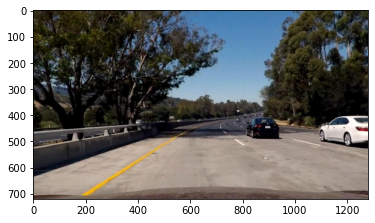

In [166]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

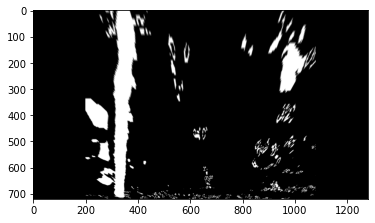

In [167]:
tresholded_img = get_tresholded_img(test_img)
tresholded_img = cv2.warpPerspective(tresholded_img,M,None)
cut_edges_(tresholded_img)
plt.imshow(tresholded_img, cmap='gray')

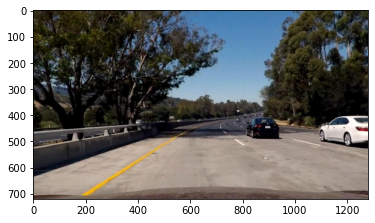

In [168]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

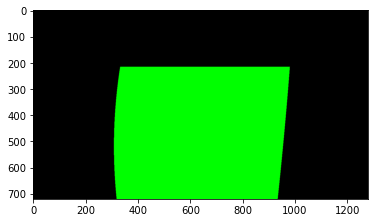

In [147]:
img, curv,_,_ = LaneDetector().get_lanes(tresholded_img)
plt.imshow(img)

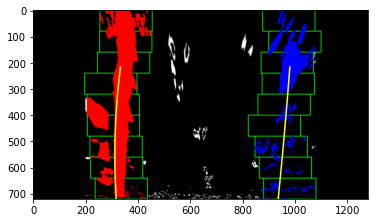

In [169]:
img, curv,_,_ = LaneDetector().get_lanes(tresholded_img, True)
plt.imshow(img)

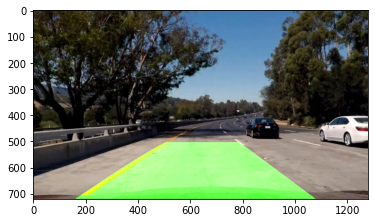

In [149]:
img,_,_,_ = LaneDetector().get_lanes(tresholded_img)
result_mask =  cv2.warpPerspective(img,Minv,None)
result = np.copy(test_img)
result[result_mask != 0] = result_mask[result_mask != 0]
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [188]:
class Processor:
    def __init__(self,calibration_images):
        self.i = 0
        self.detector = LaneDetector()
        mtx, dist, rvecs, tvecs, _, _ = clalibrate_camera(calibration_images)
        M,Minv = getPerspectiveTransformMatrix()
        self.mtx = mtx
        self.dist = dist
        self.M = M
        self.Minv = Minv
        
        
        
    def add_text_(self,img,text):    
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (30,40)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2

        cv2.putText(img,text, 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)
    
    def cut_edges_(self,img,length = 200):
        img[:,0:length] = 0
        img[:,img.shape[1] - length:img.shape[1]] = 0
    def offset(self,mask):
        xm_per_pix = 3.7/700
        shape = mask.shape
        last_row = mask[-1,:]
        middle = shape[0] / 2
        masked_middle = np.mean(last_row.nonzero())
        return (masked_middle - middle) * xm_per_pix
    def process_image(self,image):
        
        undistorted = cv2.undistort(image, self.mtx, self.dist, None)
        tresholded_img = get_tresholded_img(undistorted)
        warped = cv2.warpPerspective(tresholded_img,self.M,None)
        self.cut_edges_(warped)
        lanes, curv,lc,rc = self.detector.get_lanes(warped,enable_smothing=True, enable_drop_fix=True)
        result_mask =  cv2.warpPerspective(lanes,self.Minv,None)
        offset = self.offset(result_mask)
        result = np.copy(image)
        result[result_mask != 0] = result_mask[result_mask != 0]
        
        self.add_text_(result,'Frame: {}, curvature: {:.2f} meters, offset: {:.2f} meters l:{:.2f} r:{:.2f}'.format(self.i, curv,offset,lc,rc))
        self.i +=1
        
#         result = np.concatenate([result,np.dstack((warped_hoffed, warped_hoffed, warped_hoffed))])
        return result
    

In [189]:
output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
# output = 'challenge_video_out.mp4'
# clip1 = VideoFileClip("challenge_video.mp4")
# output = 'harder_challenge_video_out.mp4'
# clip1 = VideoFileClip("harder_challenge_video.mp4")

In [195]:

# clip1 = clip1.subclip(0,3)
processor = Processor(calibration_images)
clip = clip1.fl_image(processor.process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)


t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4



Moviepy - Done !
Moviepy - video ready project_video_out.mp4
Wall time: 4min 8s


In [196]:
processor.detector.print_stats()

Recalcs: 127, Fits_changed: 1247


In [197]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

1277.6240736733973
1555.0013168328535


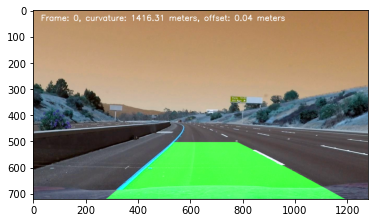

In [18]:
proc = Processor(calibration_images)
proc_image = cv2.imread('project/frame0596.jpeg')
proc_image = cv2.imread('project/frame0001.jpeg')
# proc_image = cv2.imread('project/frame0703.jpeg')
# proc_image = cv2.imread('challenge/frame0060.jpeg')
# proc_image =  cv2.imread('test_images/straight_lines2.jpg')
plt.imshow(proc.process_image(proc_image))

In [19]:
# clip1.write_images_sequence('challenge/frame%04d.jpeg')
plt.imsave('result.jpg', cv2.cvtColor(proc.process_image(proc_image), cv2.COLOR_BGR2RGB))

1277.6240736733876
1553.708794475053


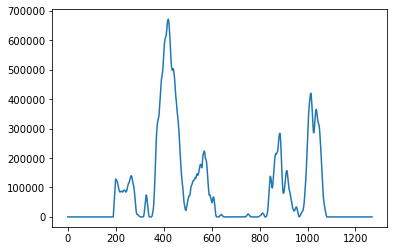

In [20]:
plt.plot(hist(tresholded_hoffed))

In [193]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def curvature(left_fit, right_fit,img):
    def curv_(x,y):
        ym_per_pix = 30/720 
        xm_per_pix = 3.7/700 
        x_ = x*xm_per_pix
        y_ = y *  ym_per_pix
        fit = np.polyfit(y_,x_,2) 

        A = fit[0]
        B = fit[1]
        y_ = np.max(y_)
        r = ((1 +(2*A*y_+B)**2)**1.5)/np.absolute(2*A)
        return r
    
    left_fitx,right_fitx,ploty = get_fit_(left_fit, right_fit,img)
    l_curv = curv_(left_fitx,ploty)
    r_curv = curv_(right_fitx,ploty)
    return np.mean([l_curv,r_curv]),l_curv,r_curv
    
    

def hist(img,hist_window = 5, y_k = 2):
    ylen = int(img.shape[0] / y_k)
    
    bottom_half = img[ylen:,:]
    
    histogram = np.sum(bottom_half, axis=0)
    histogram = [np.sum(histogram[dot-hist_window:dot+hist_window]) for dot in np.arange(hist_window, len(histogram) - hist_window)]
#     histogram =[np.mean(histogram[dot-hist_window:dot+hist_window]) for dot in np.arange(hist_window, len(histogram) - hist_window)]

    histogram = np.array(histogram)
    
    return histogram

def get_r_and_l_mid_(img):
    
    hist_window = 5
    histogram = hist(img,hist_window)
    deep_hist = hist(img,hist_window,10)
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_weight = histogram[np.argmax(histogram[:midpoint])]
    rightx_weight = histogram[midpoint+np.argmax(histogram[midpoint:])]
    
    leftx_base = np.argmax(histogram[:midpoint]) +hist_window
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint + hist_window
    if(leftx_weight > (3*rightx_weight)):
        r_hist = deep_hist[midpoint:]
        rightx_base = np.argmax(r_hist)+ midpoint + hist_window
    if(rightx_weight > (3*leftx_weight)):
        l_hist = deep_hist[:midpoint]
        leftx_base = np.argmax(l_hist)+ hist_window
    
    return leftx_base,rightx_base
    
    

def search_around_poly_(binary_warped,left_fit,right_fit, margin = 100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = None
    right_lane_inds = None
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty

def find_lane_pixels_(binary_warped,nwindows = 9, margin = 100, minpix = 50):
    hist_img = binary_warped
    hist_window = 5    
    histogram = hist(hist_img,hist_window)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint]) +hist_window
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint + hist_window
    
    leftx_base,rightx_base = get_r_and_l_mid_(hist_img)
   
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []
    rectangels = []
    
    for window in range(nwindows):
        
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
         
        rectangels.append(((win_xleft_low,win_y_low),(win_xleft_high,win_y_high)))
        rectangels.append(((win_xright_low,win_y_low),(win_xright_high,win_y_high)))
               
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
      
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))


    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, rectangels#,leftx_base,rightx_base


def get_fit_(left_fit, right_fit, binary_warped):    
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ploty = ploty[int(binary_warped.shape[0]*0.3):]
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx,right_fitx,ploty

def fill_poly_(image,left_fitx,right_fitx,ploty, color):
    points_left = zip(left_fitx,ploty)   
    points_right = zip(right_fitx,ploty)
    points_left = [[x,y] for x,y in points_left]
    points_right = [[x,y] for x,y in points_right]
    points_right = points_right[::-1]
    points = np.concatenate((points_left, points_right))
    points = np.int32(points)
    cv2.fillPoly(image, [points], color=color)

class LaneDetector:
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.i = 0
        self.recalc_counter = 0
        self.fits_changed = 0
        self.curr_curv = None
    
    def print_stats(self):
        print("Recalcs: {}, Fits_changed: {}".format(self.recalc_counter, self.fits_changed))
         
    def get_lanes(self, binary_warped,debug = False, enable_drop_fix = True, enable_smothing = True, smooth_k = 0.7):
        rectangels = None
        if (not enable_smothing) or (self.i%10 == 0) or (self.left_fit is None) or (self.right_fit is None):
            self.recalc_counter+=1
            leftx, lefty, rightx, righty, rectangels = find_lane_pixels_(binary_warped)
        else:
            leftx, lefty, rightx, righty = search_around_poly_(binary_warped,self.left_fit,self.right_fit)
        if len(leftx)!=0:
            new_left_fit = np.polyfit(lefty,leftx,2) 
        else:
            new_left_fit = self.left_fit
        
        if len(rightx)!=0:
            new_right_fit = np.polyfit(righty,rightx,2)
        else:
            new_right_fit = self.right_fit
        
        
        if(self.left_fit is None or self.right_fit is None):
            self.left_fit = new_left_fit
            self.right_fit = new_right_fit
#         else:

        left_diff = abs(self.left_fit[2] - new_left_fit[2])
        right_diff = abs(self.right_fit[2] - new_right_fit[2]) 
        fit_diff = (new_right_fit[2]-new_left_fit[2])
        if((not enable_drop_fix) or(fit_diff < 800 and fit_diff>400)):
            self.fits_changed += 1
            k = smooth_k
            self.left_fit = k*self.left_fit + (1-k)* new_left_fit
            self.right_fit = k*self.right_fit + (1-k)* new_right_fit
        
        
#         curv, lc,rc = curvature(new_left_fit,new_right_fit, binary_warped)
#         if(max(lc,rc) / min(lc,rc) < 4 ):
#             self.fits_changed += 1
#             k = smooth_k
#             self.left_fit = k*self.left_fit + (1-k)* new_left_fit
#             self.right_fit = k*self.right_fit + (1-k)* new_right_fit
        
        
        curv, lc,rc = curvature(self.left_fit,self.right_fit, binary_warped)
        if(max(lc,rc) / min(lc,rc) < 4 ):
            self.curr_curv = curv
            
            
        left_fitx,right_fitx,ploty = get_fit_(self.left_fit,self.right_fit,binary_warped)
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        if debug:
            if rectangels is not None:
                for low, high in rectangels:        
                    cv2.rectangle(out_img,low,high,(0,255,0), 2) 

            out_img[lefty, leftx] = [255, 0, 0]
            out_img[righty, rightx] = [0, 0, 255]

            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
        else:
            out_img[:,:] = [0,0,0,]
            fill_poly_(out_img,left_fitx,right_fitx,ploty,[0, 255, 0])
        self.i += 1
        return out_img,self.curr_curv,lc,rc

In [21]:
700 *3.7/700

3.7

In [159]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

image = test_img

def interactive_mask(low, high, dir_low, dir_high, ksize = 15):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray =cv2.equalizeHist(gray)
    
    x_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(dir_low, dir_high))
    channel = np.zeros_like(x_binary)
    channel = x_binary*dir_binary
#     space = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
#     channel =cv2.equalizeHist(space[:,:,2])
#     channel = color_treshold(channel, (low,high))
    
    
    plt.figure(figsize=(10,10))
    plt.imshow(channel,cmap='gray')

interact(interactive_mask, low=(0,255), high=(0,255),dir_low=(0, np.pi/2), dir_high=(0, np.pi/2))


interactive(children=(IntSlider(value=127, description='low', max=255), IntSlider(value=127, description='high…

<function __main__.interactive_mask(low, high, dir_low, dir_high, ksize=15)>

In [ ]:


    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    lab_b =cv2.equalizeHist(lab[:,:,2])
    lab_b = color_treshold(lab_b, (240,255))
#     lab_b = color_treshold(lab_b, (250,255))
    
    luv = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
    luv_l =cv2.equalizeHist(luv[:,:,0])
    luv_l = color_treshold(luv_l, (240,255))

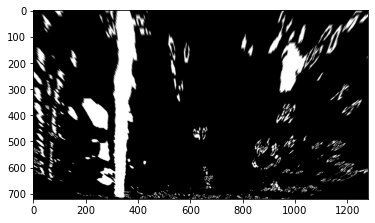

In [164]:
tresholded_img = get_tresholded_img(test_img)
tresholded_img = cv2.warpPerspective(tresholded_img,M,None)
# cut_edges_(tresholded_img)
plt.imshow(tresholded_img, cmap='gray')